# FEATURE SELECTION AND MODEL SELECTION 
Building upon the data cleaning and exploratory analysis performed in the previous module, this notebook focuses on establishing a robust validation framework and identifying the most predictive clinical features. 


**Workflow for this module:**
1. **Stratified K-fold cross validation definition and benchmark set creation**: Given the significant class imbalance observed in the target variable, we adopt a **Stratified K-Fold cross-validation** strategy. This ensures that the distribution of disease stages remains consistent across all five training folds and the independent benchmark set, preventing the model from developing biases due to underrepresented classes during the validation phase.
2. **Preliminary Tree-Architecture Selection**:Before proceeding with feature selection, we must identify the most reliable "feature ranker." We perform an architectural comparison between a Standard Random Forest and a Balanced Random Forest. Since standard impurity measures (like Gini) can be biased towards majority classes, we evaluate whether internal re-sampling techniques (Balanced RF) provide a statistically significant advantage in terms of MCC and recall for minority classes. The superior model is then utilized as the engine for our stability feature selection framework. In this protocol, for each fold, the chosen tree model ranks features by Gini Importance. We then iteratively test subsets of the top-k features to find the specific number of features that maximizes validation performance (MCC) for the specific estimator we want to test. Features included in these optimal subsets receive a "vote," and finally, we aggregate these votes across all folds, selecting only those features that appear with high consistency (frequency > 80%).
3. **Tree-based Stability Selection**:We first apply the stability framework described above using the winner of the architectural comparison as the estimator. This step aims to select a feature signature specifically optimized for orthogonal decision boundaries and capable of capturing the complex feature interactions typical of tree-based ensembles.
4. **Kernel-based Stability Selection (SVM RBF)**: Since the biological decision boundary might be highly non-linear and smooth—nuances not fully captured by the rectangular splits of trees, we perform a parallel stability selection using the Support Vector Machine with RBF kernel as the estimator. 
5. **Linear-based Stability Selection**:To test simpler hypotheses and ensure interpretability, we conduct a third selection process using Logistic Regression. This assumes a linear relationship between biomarkers and disease stage. By optimizing the feature set specifically for a linear solver, we can verify whether the complexity of non-linear models is strictly necessary or if a simpler linear baseline yields comparable results.
6. **Final Output Serialization**:The distinct feature sets identified one optimized for tree-based model, one for kernel-based model and one for linear model are serialized and saved in .pkl files. These curated subsets will be the input for the final hyperparameter optimization and testing phase in the next module `03_Optimization_and_Benchmark_Testing.ipynb`.

In [1]:
!pip install imbalanced-learn -q

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import matthews_corrcoef, confusion_matrix, classification_report, make_scorer
from sklearn.feature_selection import RFECV
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.linear_model import LogisticRegression
import sys
import os
module_path = os.path.abspath(os.path.join('..', 'codes'))
if module_path not in sys.path:
    sys.path.append(module_path)
from stability_feature_sel import feat_sel


## 1. Stratified K-fold cross validation definition and benchmark set creation

In [3]:
df=pd.read_csv('../data/dataset_refined.csv')

In [4]:
df.set_index('ID', inplace=True) #let's set ID column like index. so we will don't have problem with that during analysis.
df

,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
ID,,,,,,,,,,,,,,,,,
1,0,0.827904,0,1,1,1,2,2.485914,-0.478678,-2.194559,0.676705,-0.123847,0.271931,0.738724,-0.758778,1.470371,4.0
2,0,0.608395,0,0,1,1,0,-0.476689,-0.294810,1.478942,-0.515774,2.532642,-0.159629,-0.580631,-0.432105,-0.125301,3.0
3,0,1.898239,1,0,0,0,1,-0.410362,-0.859868,-0.095416,1.308017,-0.686329,-0.467356,-1.098949,-1.169754,1.270912,4.0
4,0,0.446938,0,0,1,1,1,-0.321927,-0.554916,-2.337683,-0.398864,1.936935,-1.093939,-0.517805,-0.832543,-0.424490,4.0
5,1,-1.127724,0,0,1,1,0,0.031817,-0.397955,0.023854,0.524722,-0.613796,-0.166165,-0.831937,-1.327822,0.173887,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,0,1.056743,0,0,1,0,0,-0.631452,-0.545947,0.143123,-0.866503,-0.554834,-0.557448,-0.187966,0.273930,-0.324760,2.0
309,1,0.783847,0,0,0,0,0,-0.631452,-0.483163,-1.836751,-0.667757,-0.382158,-0.928416,-0.674871,-0.326727,0.074158,2.0
310,0,1.165591,0,0,0,0,0,-0.344036,0.297156,-0.405516,-0.691139,-0.126187,0.855765,-0.392152,-0.295113,-0.524219,2.0


In [5]:
X = df.drop(columns=['Stage'])
y = df['Stage']
X_dev, X_benchmark, y_dev, y_benchmark = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42) #this part divides the set into dev set (useful for all procedure like model and feature selection) and benchmark set, useful to final model evaluations.
df['Set'] = '0'
for idx,row in X_benchmark.iterrows():# this for cycle marks Benchmark set sample
    df.loc[idx,'Set']='Benchmark'
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)



In [6]:
for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X_dev, y_dev)): #this for loop is useful to marks the respective set number. 
    real_test_indices = X_dev.index[test_idx]
    df.loc[real_test_indices, 'Set'] = str(fold_idx + 1)

In [7]:
df

,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Set
ID,,,,,,,,,,,,,,,,,,
1,0,0.827904,0,1,1,1,2,2.485914,-0.478678,-2.194559,0.676705,-0.123847,0.271931,0.738724,-0.758778,1.470371,4.0,Benchmark
2,0,0.608395,0,0,1,1,0,-0.476689,-0.294810,1.478942,-0.515774,2.532642,-0.159629,-0.580631,-0.432105,-0.125301,3.0,Benchmark
3,0,1.898239,1,0,0,0,1,-0.410362,-0.859868,-0.095416,1.308017,-0.686329,-0.467356,-1.098949,-1.169754,1.270912,4.0,Benchmark
4,0,0.446938,0,0,1,1,1,-0.321927,-0.554916,-2.337683,-0.398864,1.936935,-1.093939,-0.517805,-0.832543,-0.424490,4.0,Benchmark
5,1,-1.127724,0,0,1,1,0,0.031817,-0.397955,0.023854,0.524722,-0.613796,-0.166165,-0.831937,-1.327822,0.173887,3.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,0,1.056743,0,0,1,0,0,-0.631452,-0.545947,0.143123,-0.866503,-0.554834,-0.557448,-0.187966,0.273930,-0.324760,2.0,2
309,1,0.783847,0,0,0,0,0,-0.631452,-0.483163,-1.836751,-0.667757,-0.382158,-0.928416,-0.674871,-0.326727,0.074158,2.0,5
310,0,1.165591,0,0,0,0,0,-0.344036,0.297156,-0.405516,-0.691139,-0.126187,0.855765,-0.392152,-0.295113,-0.524219,2.0,2


Let's see the stage distribution in the training sets

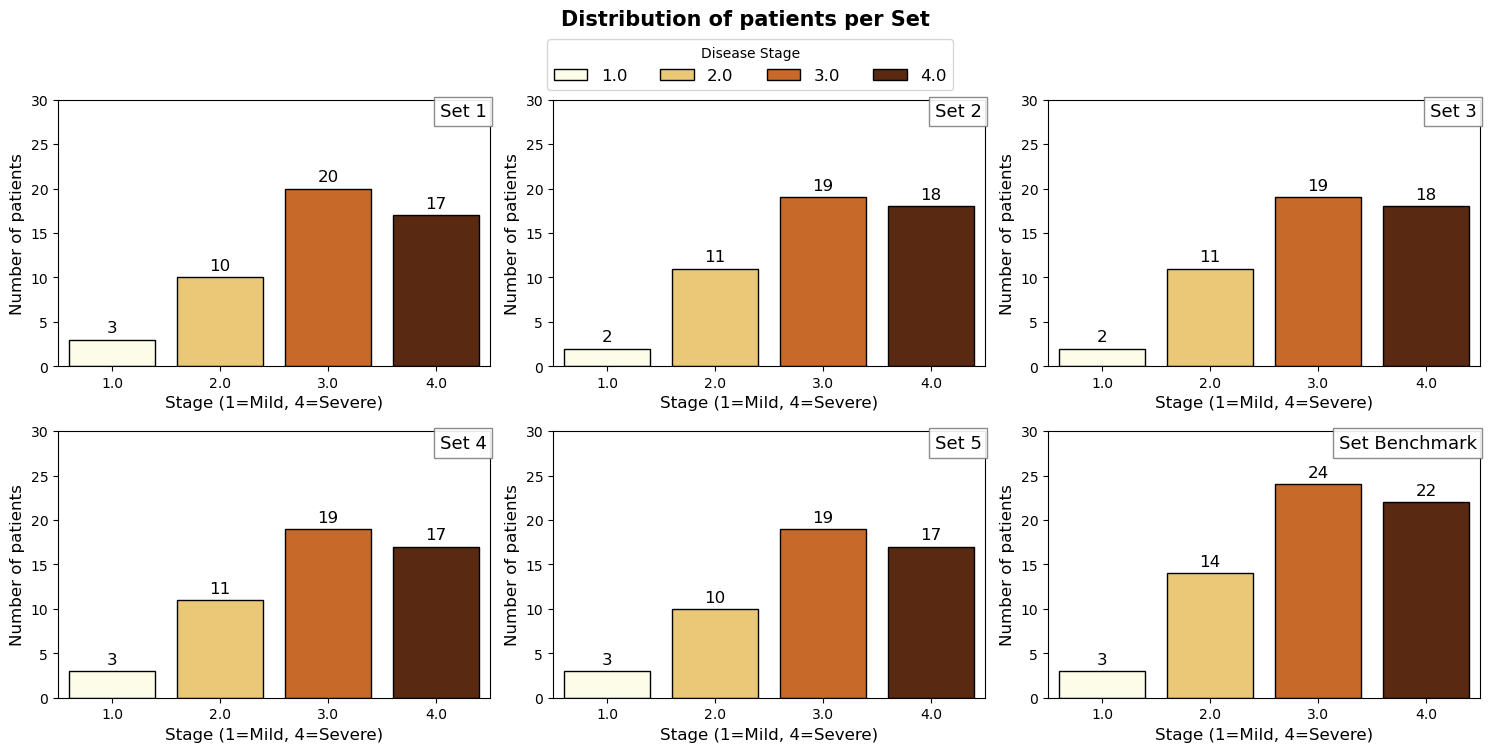

In [8]:
plt.figure(figsize=(15, 10))
sets=df['Set'].sort_values().unique().tolist()
for i in range(1,len(sets)+1):
    df_case=df.query(f'Set=="{sets[i-1]}"')
    stage_counts = df_case['Stage'].value_counts().sort_index() # calculate absolute frequency for each stage
    data_refinded_summary = pd.DataFrame({ 'Counts': stage_counts}) # create a summary dataframe to inspect the distribution before plotting

    # plotting the percentages using a barplot to visualize the class imbalance
    fig=plt.subplot(3, 3, i)
    ax=sns.barplot(x='Stage', y='Counts', data=data_refinded_summary, hue='Stage', legend=True, palette='YlOrBr', edgecolor='black')
    plt.ylim(0, 30)
    fig.text(0.992, .989, f'Set {sets[i-1]}', 
                transform=fig.transAxes,  
                ha='right', va='top',    
                fontsize=13,
                bbox=dict(fc="white", ec="gray", alpha=0.9)) 
    # adding precise percentage labels on top of the bars
    for j in range(len(ax.containers)):
        ax.bar_label(ax.containers[j], fmt='%d', padding=3, fontsize=12);
    fig.get_legend().remove() # remove individual legends to make possible print only one legend for all the graphs.
    plt.xlabel('Stage (1=Mild, 4=Severe)', fontsize=12)
    plt.ylabel('Number of patients', fontsize=12)

# setting titles and axis labels
plt.suptitle('Distribution of patients per Set', fontsize=15, y=1.035, weight='bold' )
handles, labels = fig.get_legend_handles_labels() # extract legend handles and labels to use them globally 
# extending y-axis limit to prevent labels from being cut off and save the figure
plt.tight_layout()
fig.legend(handles, labels, ncol=4, title='Disease Stage', fontsize=12, bbox_to_anchor=(-0.2,2.5))
plt.savefig('../figures/02_set_patients_distr_per_stage.svg')
plt.show()

So we have seen that the stratification kfold worked fine, and we have a balanced distribution between the 5 sets.

In [9]:

#let's prepare data for the further analysis
X = X_dev.copy().reset_index(drop=True)
y = y_dev.copy().reset_index(drop=True)
training=df.query("Set=='1' or Set=='2' or Set=='3' or Set=='4' or Set=='5'")


## 2. Preliminary Tree-Architecture Selection

The analytical process begins by evaluating a Standard Random Forest against a Balanced Random Forest. This comparison is critical because standard tree-based algorithms naturally tend to bias predictions toward the majority class to minimize global error, often failing to capture minority patterns (e.g., Stage 1 or Stage 4). By contrast, the Balanced Random Forest employs internal down sampling techniques to equilibrate the training distribution for each individual tree. We empirically evaluate these architectures across a wide range of estimators (n_estimators) to determine if the balanced approach yields a substantial improvement in classification performance (measured via MCC), thereby justifying its adoption for the subsequent feature selection phase. This comprensive sweep allows us to assess the stability and generalizability of both models before finalizing the architecture.

----------------------------------------------------------------------------------------------------
Classic Random forest with 100 estimators MCC: 0.2362858368195319
Balanced Random forest with 100 estimators MCC: 0.2844657746059471
----------------------------------------------------------------------------------------------------
Classic Random forest with 200 estimators MCC: 0.22396193866527697
Balanced Random forest with 200 estimators MCC: 0.3395336492694041
----------------------------------------------------------------------------------------------------
Classic Random forest with 500 estimators MCC: 0.23187494086967897
Balanced Random forest with 500 estimators MCC: 0.3462776314473912
----------------------------------------------------------------------------------------------------
Classic Random forest with 800 estimators MCC: 0.23102037589965546
Balanced Random forest with 800 estimators MCC: 0.33276803343407046
------------------------------------------------------------

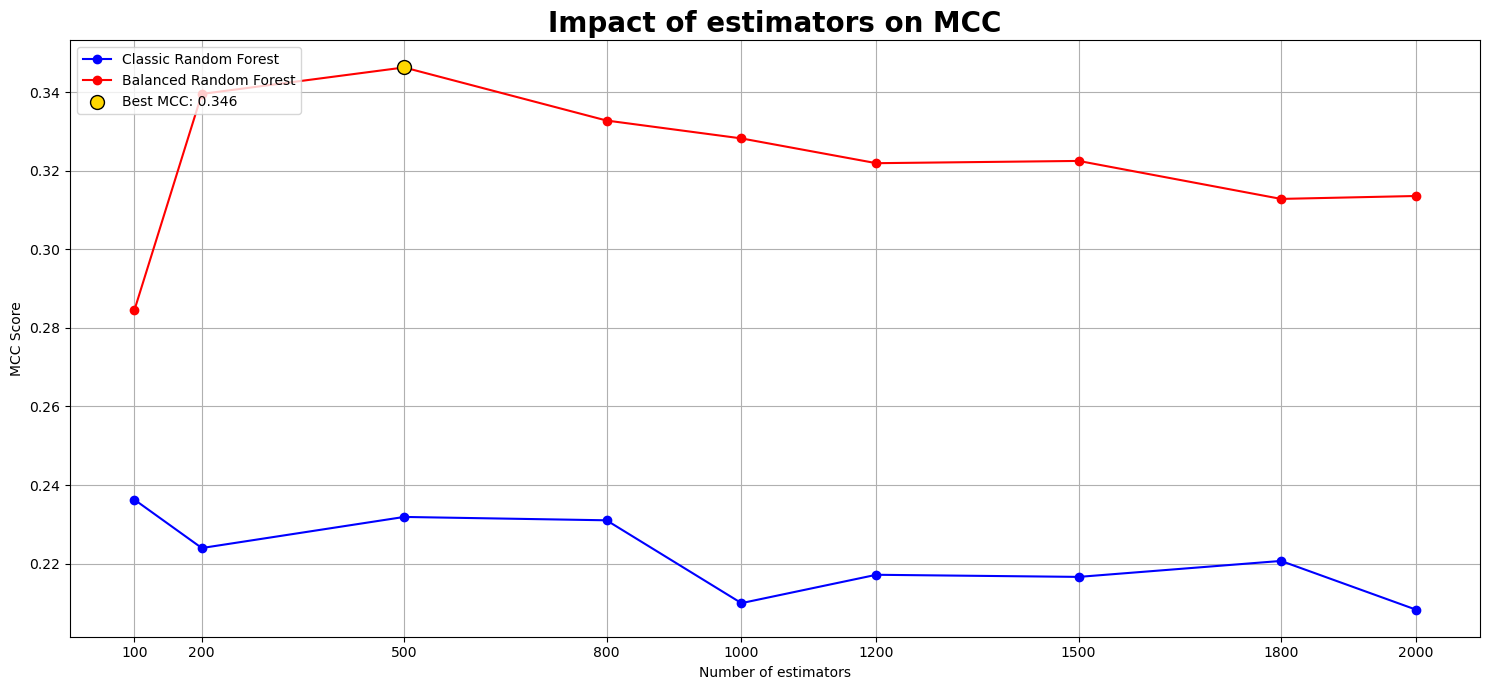

Best feature selection model is Balanced Random Forest Classifier with 500 estimators. MCC: 0.3462776314473912


In [10]:
n_trees_list = [100, 200, 500, 800, 1000,1200,1500,1800,2000]
results_classic = []
result_balanced=[]
matthew_corr=make_scorer(matthews_corrcoef)
best_score=0


for n in n_trees_list:
    rf_classic = RandomForestClassifier(
        n_estimators=n, 
        class_weight='balanced', # Pesa di più gli errori sulle classi rare
        random_state=42, 
        n_jobs=-1
    )
    
    rf_balanced = BalancedRandomForestClassifier(
        n_estimators=n,
        sampling_strategy='all', 
        replacement=True, 
        random_state=42,
        n_jobs=-1
    )
    
    
    scores_classic = cross_val_score(rf_classic, X, y, cv=skf, scoring=matthew_corr).mean()
    scores_balanced = cross_val_score(rf_balanced, X, y, cv=skf, scoring=matthew_corr).mean()
    results_classic.append(scores_classic)
    result_balanced.append(scores_balanced)
    if scores_classic > best_score:
        best_model=rf_classic
        best_score=scores_classic
        best_name='Classic Random Forest Classifier'
        best_n=n
    elif scores_balanced > best_score:
        best_model=rf_balanced
        best_score=scores_balanced
        best_name='Balanced Random Forest Classifier'
        best_n=n
    
        
    print("-"*100)
    print(f"Classic Random forest with {n} estimators MCC: {scores_classic}")
    print(f"Balanced Random forest with {n} estimators MCC: {scores_balanced}")

plt.figure(figsize=(15, 7))
plt.plot(n_trees_list, results_classic, marker='o', linestyle='-', color='b', label='Classic Random Forest')
plt.plot(n_trees_list, result_balanced, marker='o', linestyle='-', color='r', label='Balanced Random Forest')
plt.scatter(best_n, best_score, color='gold', marker='o', s=100, edgecolors='black', zorder=5, label=f'Best MCC: {best_score:.3f}')
plt.xticks(n_trees_list)
plt.title("Impact of estimators on MCC",fontsize=20, weight='bold')
plt.xlabel("Number of estimators")
plt.ylabel("MCC Score")
plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.grid(True)
plt.savefig('../figures/02_mcc_diff_estimators.svg', bbox_inches='tight')
plt.show()

print(f"Best feature selection model is {best_name} with {best_n} estimators. MCC: {best_score}")




The overall low MCC stems from the severe dataset imbalance, probably due to the scarcity of Stage 1 samples, which complicates the training process.
As shown in the graph, the Balanced Random Forest (red) consistently outperforms the Classic Random Forest (blue). 
Regarding the number of estimators we can see that 500 estimators lead to the maximum MCC reachable and is essential for the balanced model. Like the Standard RF, it degrades in performance after 500 trees. Consequently, we select the Balanced Random Forest with 500 estimators as the optimal configuration for the subsequent feature selection phase. 

## 3. Tree-based Stability Selection

In [11]:
    best_model = BalancedRandomForestClassifier(
        n_estimators=500,
        sampling_strategy='all', 
        replacement=True, 
        random_state=42,
        n_jobs=-1
    )

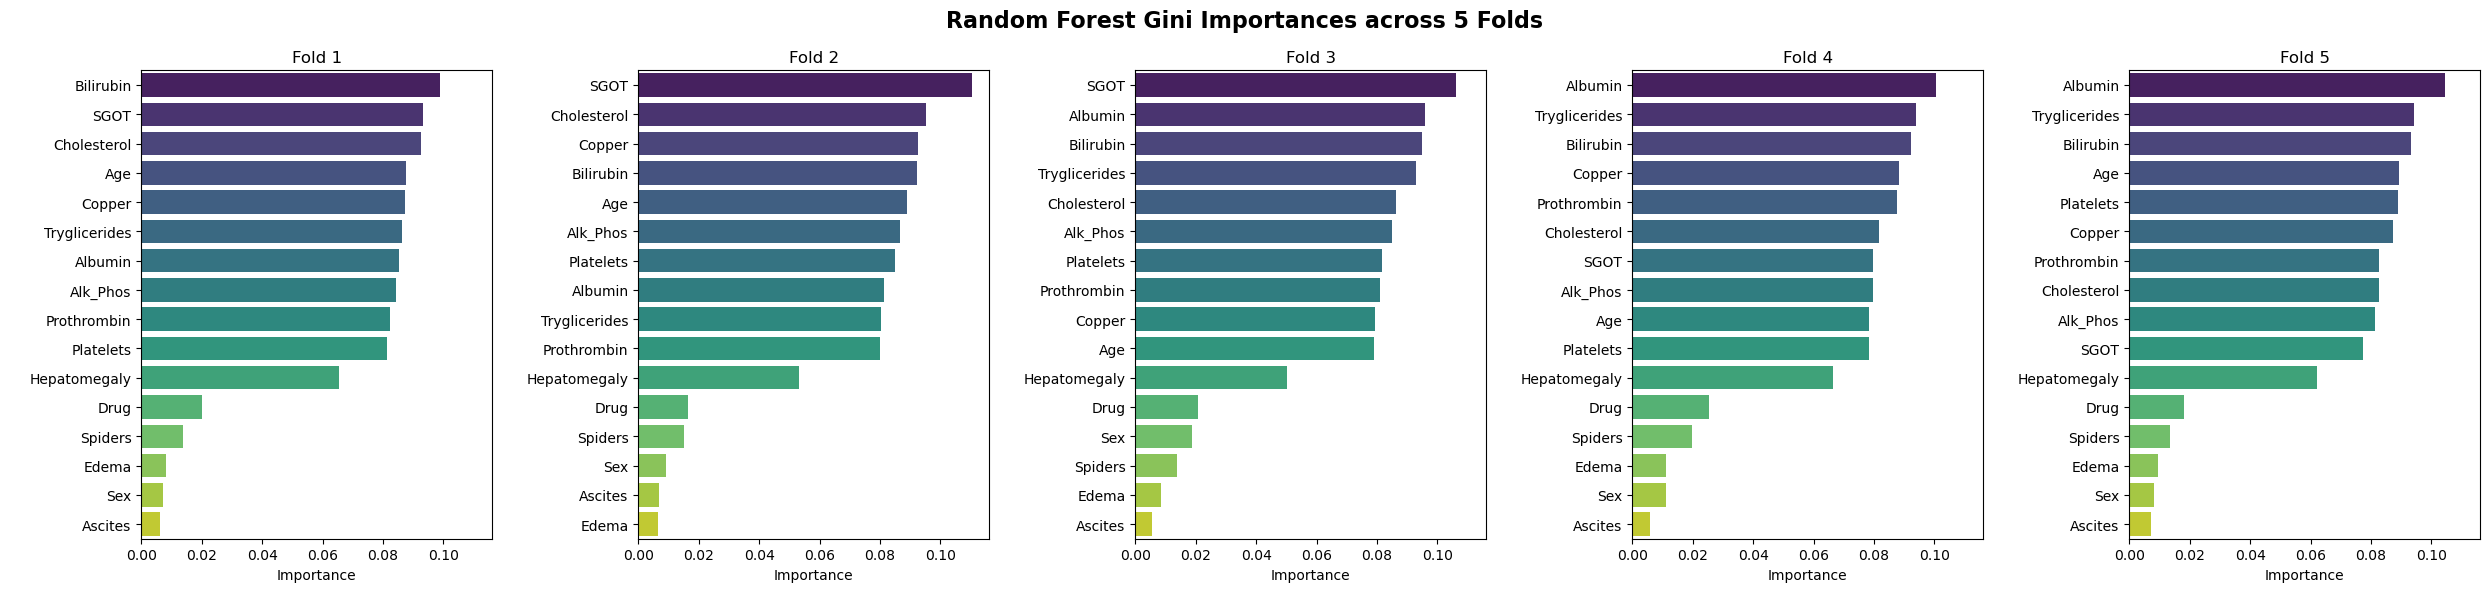

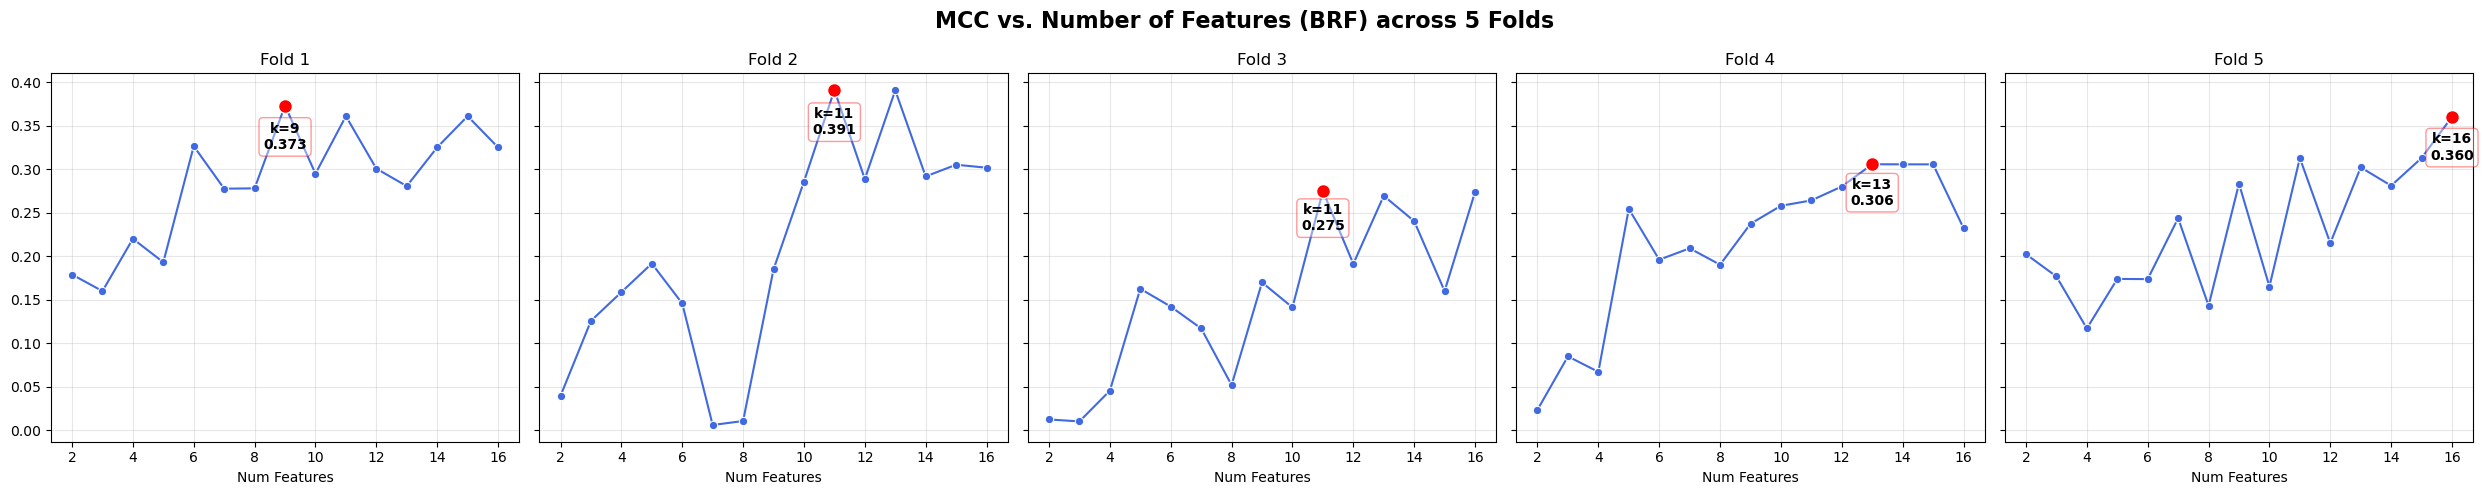

In [12]:
estimator = best_model
rf = best_model 
feature_counter = {}
results_gini = []
results_curve = []

for feature in training.drop(columns=['Set','Stage']).columns.tolist():
    feature_counter[feature] = feature_counter.get(0,0)
# iterate over the 5 cross-validation folds
for i in range(1, 6): 
    #-------dataset and estimator preparation----------------#
    # prepare train, validation, and test splits for the current fold
    training_sets = ((((i + 1) % 5) + 1), (((i + 2) % 5) + 1), (((i + 3) % 5) + 1)) 
    x_test, y_test = training.query(f"Set=='{i}'").drop(columns=['Set','Stage']), training.query(f"Set=='{i}'")['Stage']
    x_val, y_val = training.query(f"Set=='{((i)%5)+1}'").drop(columns=['Set','Stage']), training.query(f"Set=='{((i)%5)+1}'")['Stage']
    x_train, y_train = training.query(f"(Set=='{training_sets[0]}' or Set=='{training_sets[1]}' or Set=='{training_sets[2]}')").drop(columns=['Set','Stage']), training.query(f"(Set=='{training_sets[0]}' or Set=='{training_sets[1]}' or Set=='{training_sets[2]}')")['Stage']


    #---------------feature evaluation by gini importance --------------#

    
    # execute feature selection ranking
    gini_df, best_k, ks, curve = feat_sel(x_train, y_train, x_test, y_test, estimator, rf)

    # Store the resulting dataframes and curves for final plotting
    results_gini.append((i, gini_df)) 
    results_curve.append((i, ks, curve, best_k))
    
    # Update global feature counter with the selected top features
    for feature in gini_df["feature"].head(best_k):
        feature_counter[feature] = feature_counter.get(feature, 0) + 1 

#---------------------PLOTTING-------------#
# Plot 1: shows the features in order of importance (Gini importance)
fig1, axes1 = plt.subplots(1, 5, figsize=(25, 6), sharex=True)
fig1.suptitle('Random Forest Gini Importances across 5 Folds', fontsize=16, fontweight='bold')

for idx, (fold_num, fold_df) in enumerate(results_gini):
    ax = axes1[idx]
    

    sns.barplot(
        data=fold_df, 
        x="importance", 
        y="feature", 
        ax=ax, 
        palette="viridis", 
        hue="feature", 
        legend=False 
    )
    
    ax.set_title(f"Fold {fold_num}")
    ax.set_xlabel("Importance")
    ax.set_ylabel(" ")

plt.tight_layout()
plt.savefig('../figures/02_gini_imp_5cv_tree.svg', bbox_inches='tight')
plt.show()

# Plot 2: MCC testing Curve per fold per different k number of features
fig2, axes2 = plt.subplots(1, 5, figsize=(25, 5), sharey=True) 
fig2.suptitle('MCC vs. Number of Features (BRF) across 5 Folds', fontsize=16, fontweight='bold')

for idx, (fold_num, ks, curve, best_k) in enumerate(results_curve):
    ax = axes2[idx]
    
    # draw the main curve using Seaborn
    sns.lineplot(
        x=ks, 
        y=curve, 
        ax=ax, 
        marker="o", 
        color="royalblue" 
    )
    
    # highlight the best K point 
    best_mcc = curve[ks.index(best_k)]
    ax.scatter(best_k, best_mcc, color="red", s=100, zorder=5, edgecolor='white')
    
    # add text annotation for the best k (to make it more readable)
    ax.text(best_k, best_mcc - (max(curve)*0.05), 
            f"k={best_k}\n{best_mcc:.3f}", 
            ha='center', va='top', color='black', fontsize=10, fontweight='bold',
            bbox=dict(facecolor="white", alpha=0.4, edgecolor="red", boxstyle="round,pad=0.3"))
    
    ax.set_title(f"Fold {fold_num}")
    ax.set_xlabel("Num Features")
    ax.grid(True, alpha=0.3) 

plt.tight_layout()
plt.savefig('../figures/02_num_feat_5cv_tree.svg', bbox_inches='tight')
plt.show()

After evaulated the best features and the best number of features for each iteration, we evaluate which features appears more times, (80% of cases) and we will extract them for the benchmark testing procedure. This will be done equal also for the linear models. 

Feature to use: ['Age', 'Hepatomegaly', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
Number of features: 11


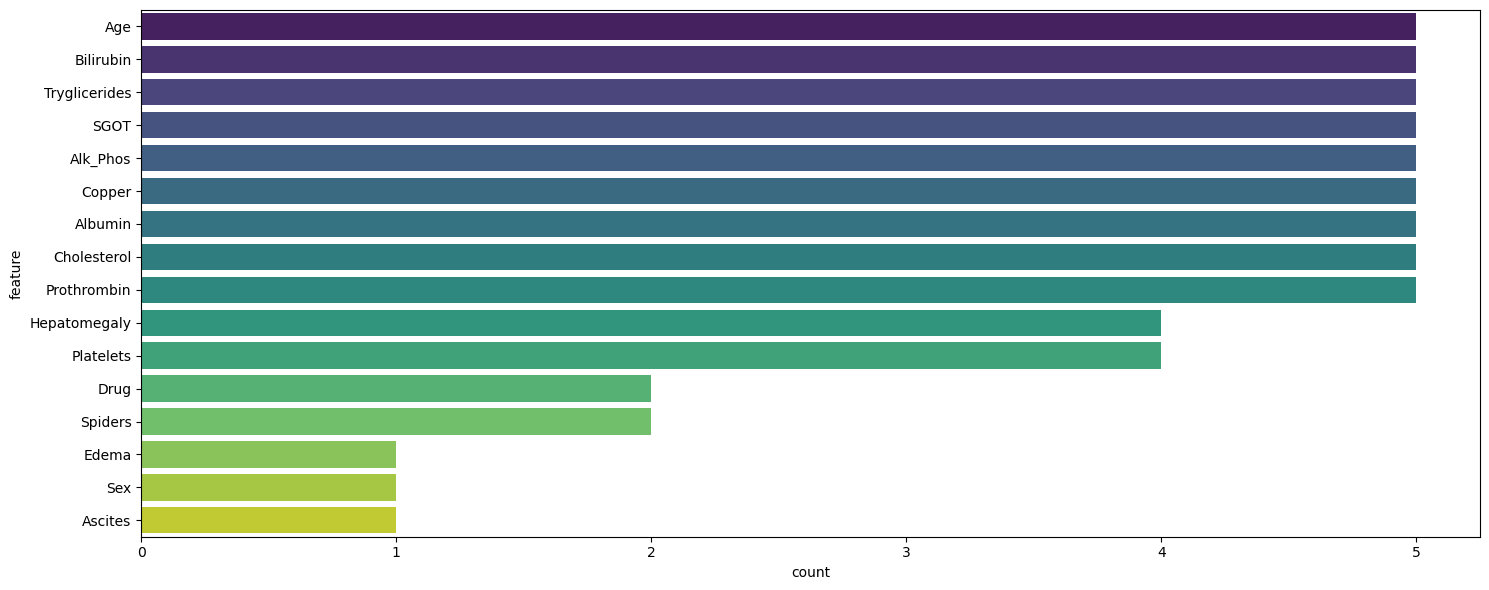

In [12]:
#Select the features that we will use for training the final model
features_to_use_tree= [k for k, v in feature_counter.items() if v >= 4]
print("Feature to use: "+ str(features_to_use_tree)+ "\n"+"Number of features: "+ str(len(features_to_use_tree)))

counter_df = pd.DataFrame(list(feature_counter.items()), columns=['feature', 'count'])
counter_df = counter_df.sort_values(by='count', ascending=False)
plt.figure(figsize=(15, 6))
sns.barplot(
    data=counter_df, 
    x="count", 
    y="feature", 
    palette="viridis",
    hue="feature",
    legend=False
    )
    

plt.tight_layout()
plt.savefig('../figures/02_counter_feat_tree.svg', bbox_inches='tight')
plt.show()

## 4. Kernel-based Stability Selection (SVM RBF)

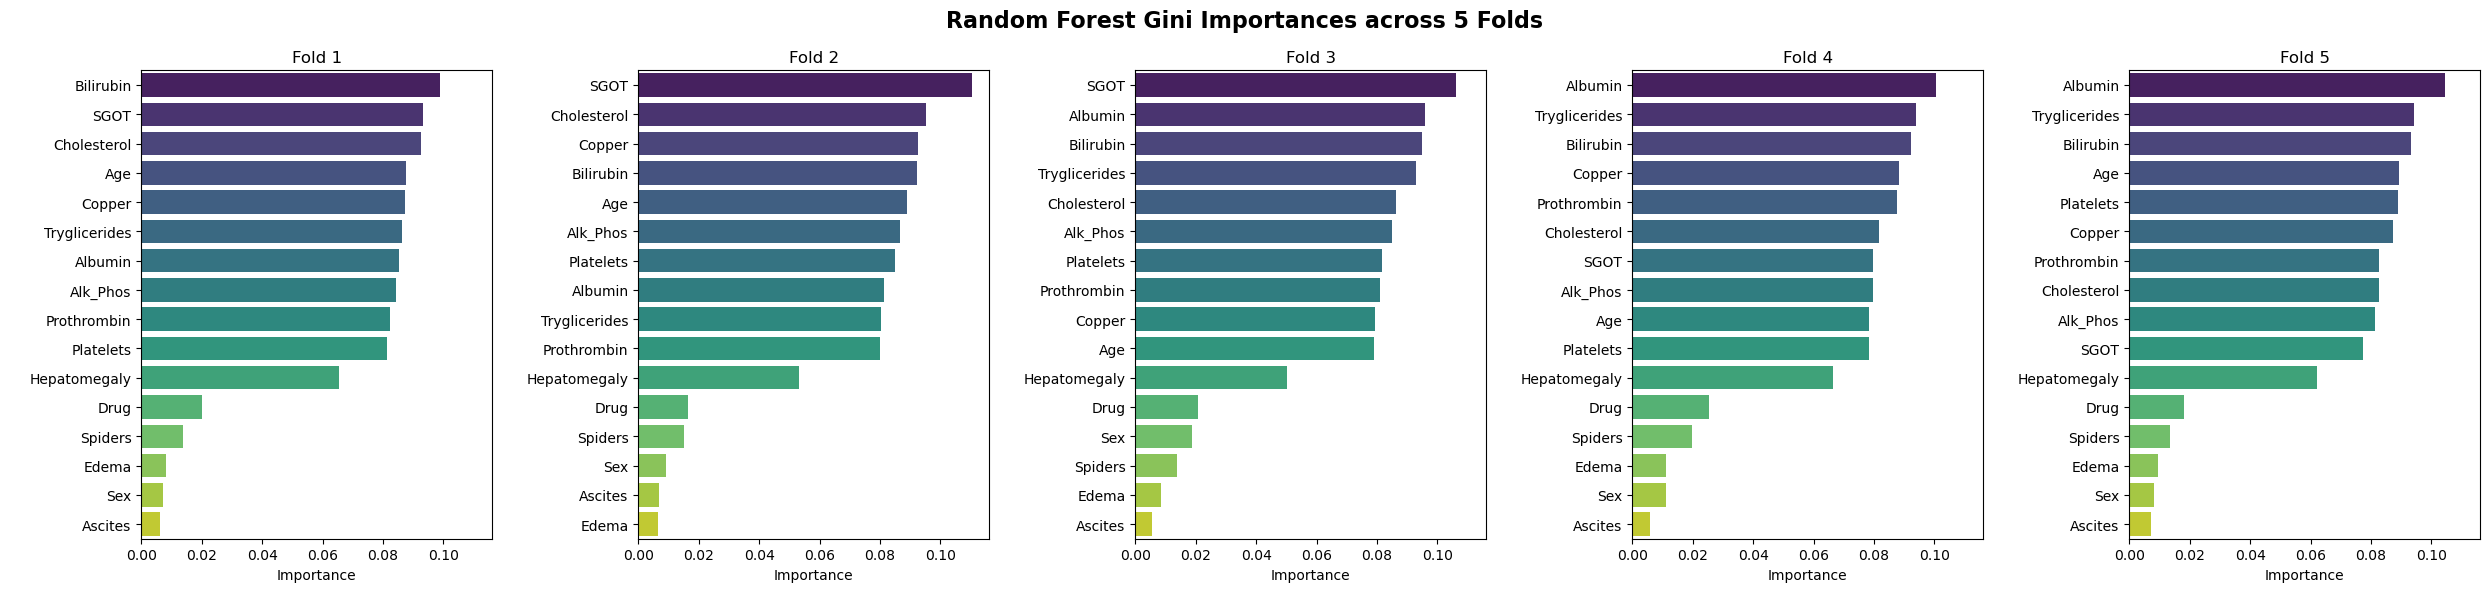

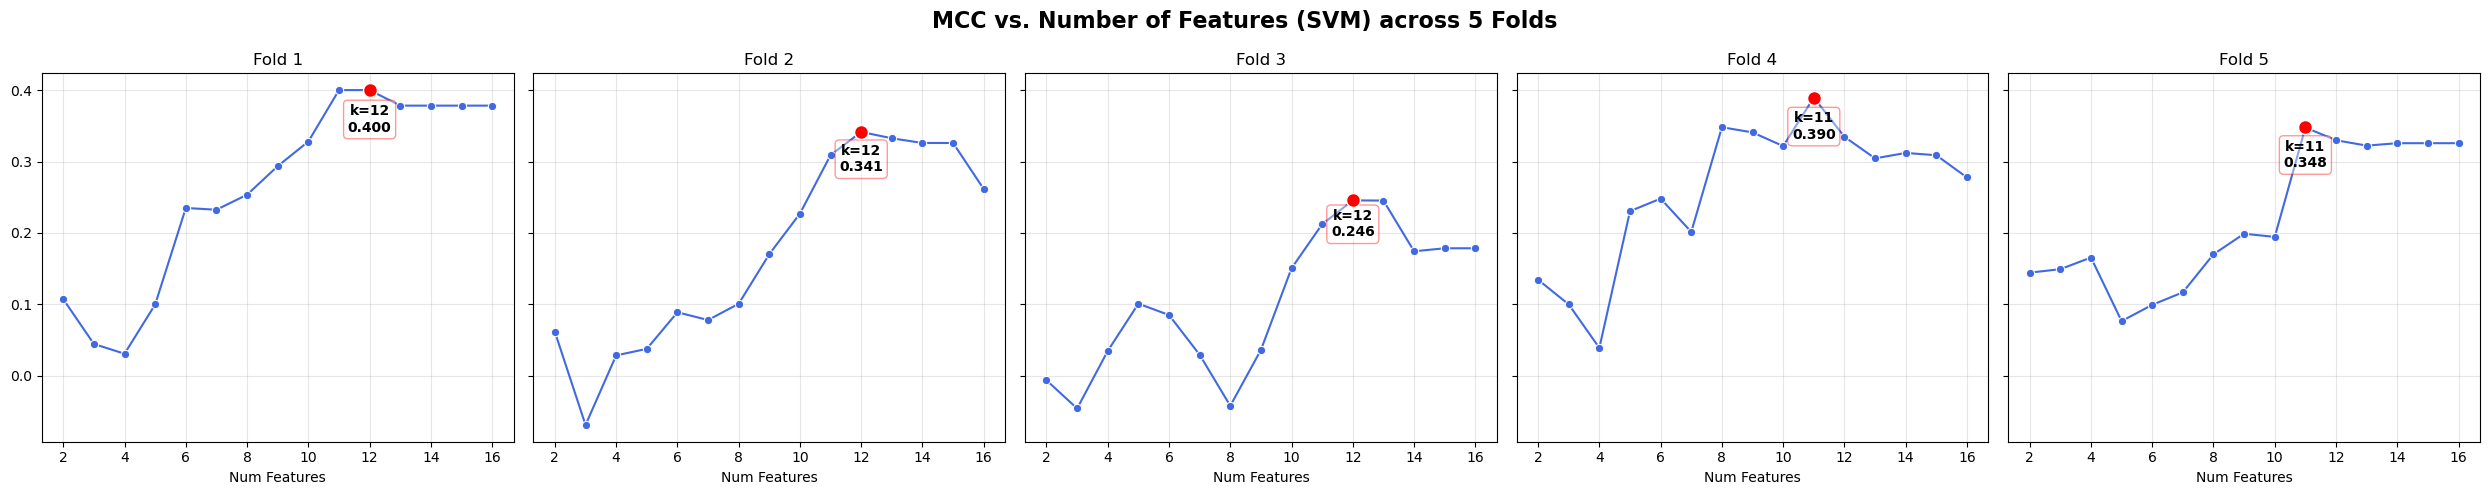

In [13]:
# initialize grids and models for SVM
C_grid = [0.1, 1.0, 10.0, 100.0]
gamma_grid = ["scale", 0.01, 0.1, 1.0]
estimator = SVC(kernel="rbf", class_weight='balanced', random_state=42)
rf = best_model 

feature_counter = {}
results_gini = []
results_curve = []

for feature in training.drop(columns=['Set','Stage']).columns.tolist():
    feature_counter[feature] = feature_counter.get(0,0)
# iterate over the 5 cross-validation folds
for i in range(1, 6): 
    #-------dataset and estimator preparation----------------#
    # prepare train, validation, and test splits for the current fold
    training_sets = ((((i + 1) % 5) + 1), (((i + 2) % 5) + 1), (((i + 3) % 5) + 1)) 
    x_test, y_test = training.query(f"Set=='{i}'").drop(columns=['Set','Stage']), training.query(f"Set=='{i}'")['Stage']
    x_val, y_val = training.query(f"Set=='{((i)%5)+1}'").drop(columns=['Set','Stage']), training.query(f"Set=='{((i)%5)+1}'")['Stage']
    x_train, y_train = training.query(f"(Set=='{training_sets[0]}' or Set=='{training_sets[1]}' or Set=='{training_sets[2]}')").drop(columns=['Set','Stage']), training.query(f"(Set=='{training_sets[0]}' or Set=='{training_sets[1]}' or Set=='{training_sets[2]}')")['Stage']

    best_mcc = -1 
    best_params_base = None

    # Grid Search for SVM hyperparameters using the validation set
    for C in C_grid: 
        for gamma in gamma_grid:
            estimator.set_params(C=C, gamma=gamma)
            estimator.fit(x_train, y_train) 
            y_pred = estimator.predict(x_val) 
            mcc = matthews_corrcoef(y_val, y_pred) 
            
            # keep the parameters that yield the best Validation MCC
            if mcc > best_mcc:
                best_mcc = mcc
                best_params_base = (C, gamma)

    #---------------feature evaluation by gini importance --------------#
    # Set the best parameters found
    estimator.set_params(C=best_params_base[0], gamma=best_params_base[1])
    
    # execute feature selection ranking
    gini_df, best_k, ks, curve = feat_sel(x_train, y_train, x_test, y_test, estimator, rf)

    # Store the resulting dataframes and curves for final plotting
    results_gini.append((i, gini_df)) 
    results_curve.append((i, ks, curve, best_k))
    
    # Update global feature counter with the selected top features
    for feature in gini_df["feature"].head(best_k):
        feature_counter[feature] = feature_counter.get(feature, 0) + 1 

#---------------------PLOTTING-------------#
# Plot 1: shows the features in order of importance (Gini importance)
fig1, axes1 = plt.subplots(1, 5, figsize=(25, 6), sharex=True)
fig1.suptitle('Random Forest Gini Importances across 5 Folds', fontsize=16, fontweight='bold')

for idx, (fold_num, fold_df) in enumerate(results_gini):
    ax = axes1[idx]
    

    sns.barplot(
        data=fold_df, 
        x="importance", 
        y="feature", 
        ax=ax, 
        palette="viridis", 
        hue="feature", 
        legend=False 
    )
    
    ax.set_title(f"Fold {fold_num}")
    ax.set_xlabel("Importance")
    ax.set_ylabel(" ")

plt.tight_layout()
plt.savefig('../figures/02_gini_imp_5cv_svm.svg', bbox_inches='tight')
plt.show()

# Plot 2: MCC testing Curve per fold per different k number of features
fig2, axes2 = plt.subplots(1, 5, figsize=(25, 5), sharey=True) 
fig2.suptitle('MCC vs. Number of Features (SVM) across 5 Folds', fontsize=16, fontweight='bold')

for idx, (fold_num, ks, curve, best_k) in enumerate(results_curve):
    ax = axes2[idx]
    
    # draw the main curve using Seaborn
    sns.lineplot(
        x=ks, 
        y=curve, 
        ax=ax, 
        marker="o", 
        color="royalblue" 
    )
    
    # highlight the best K point 
    best_mcc = curve[ks.index(best_k)]
    ax.scatter(best_k, best_mcc, color="red", s=100, zorder=5, edgecolor='white')
    
    # add text annotation for the best k (to make it more readable)
    ax.text(best_k, best_mcc - (max(curve)*0.05), 
            f"k={best_k}\n{best_mcc:.3f}", 
            ha='center', va='top', color='black', fontsize=10, fontweight='bold',
            bbox=dict(facecolor="white", alpha=0.4, edgecolor="red", boxstyle="round,pad=0.3"))
    
    ax.set_title(f"Fold {fold_num}")
    ax.set_xlabel("Num Features")
    ax.grid(True, alpha=0.3) 

plt.tight_layout()
plt.savefig('../figures/02_num_feat_5cv_svm.svg', bbox_inches='tight')
plt.show()

Feature to use: ['Age', 'Hepatomegaly', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
Number of features: 11


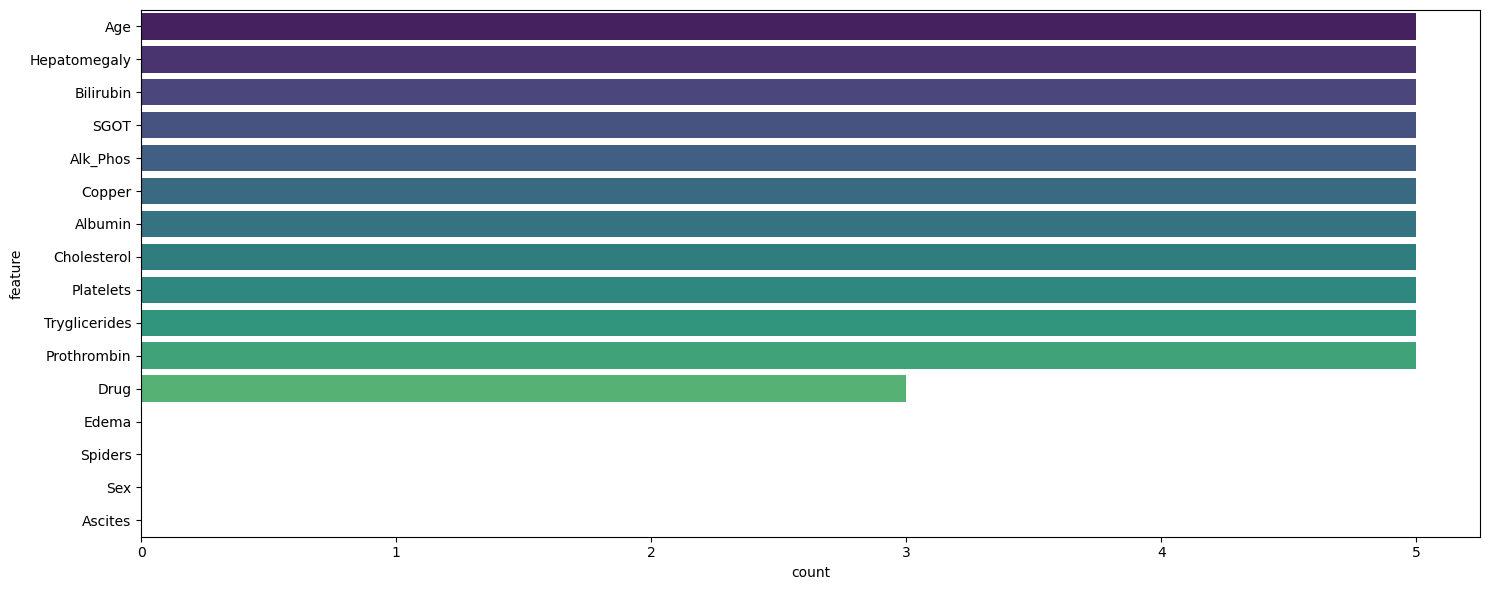

In [14]:
#Select the features that we will use for training the final model
features_to_use_svm= [k for k, v in feature_counter.items() if v >= 4]
print("Feature to use: "+ str(features_to_use_svm)+ "\n"+"Number of features: "+ str(len(features_to_use_svm)))

counter_df = pd.DataFrame(list(feature_counter.items()), columns=['feature', 'count'])
counter_df = counter_df.sort_values(by='count', ascending=False)
plt.figure(figsize=(15, 6))
sns.barplot(
    data=counter_df, 
    x="count", 
    y="feature", 
    palette="viridis",
    hue="feature",
    legend=False
    )
    

plt.tight_layout()
plt.savefig('../figures/02_counter_feat_svm.svg', bbox_inches='tight')
plt.show()

## Linear-based Stability Selection (Logistic Regression)

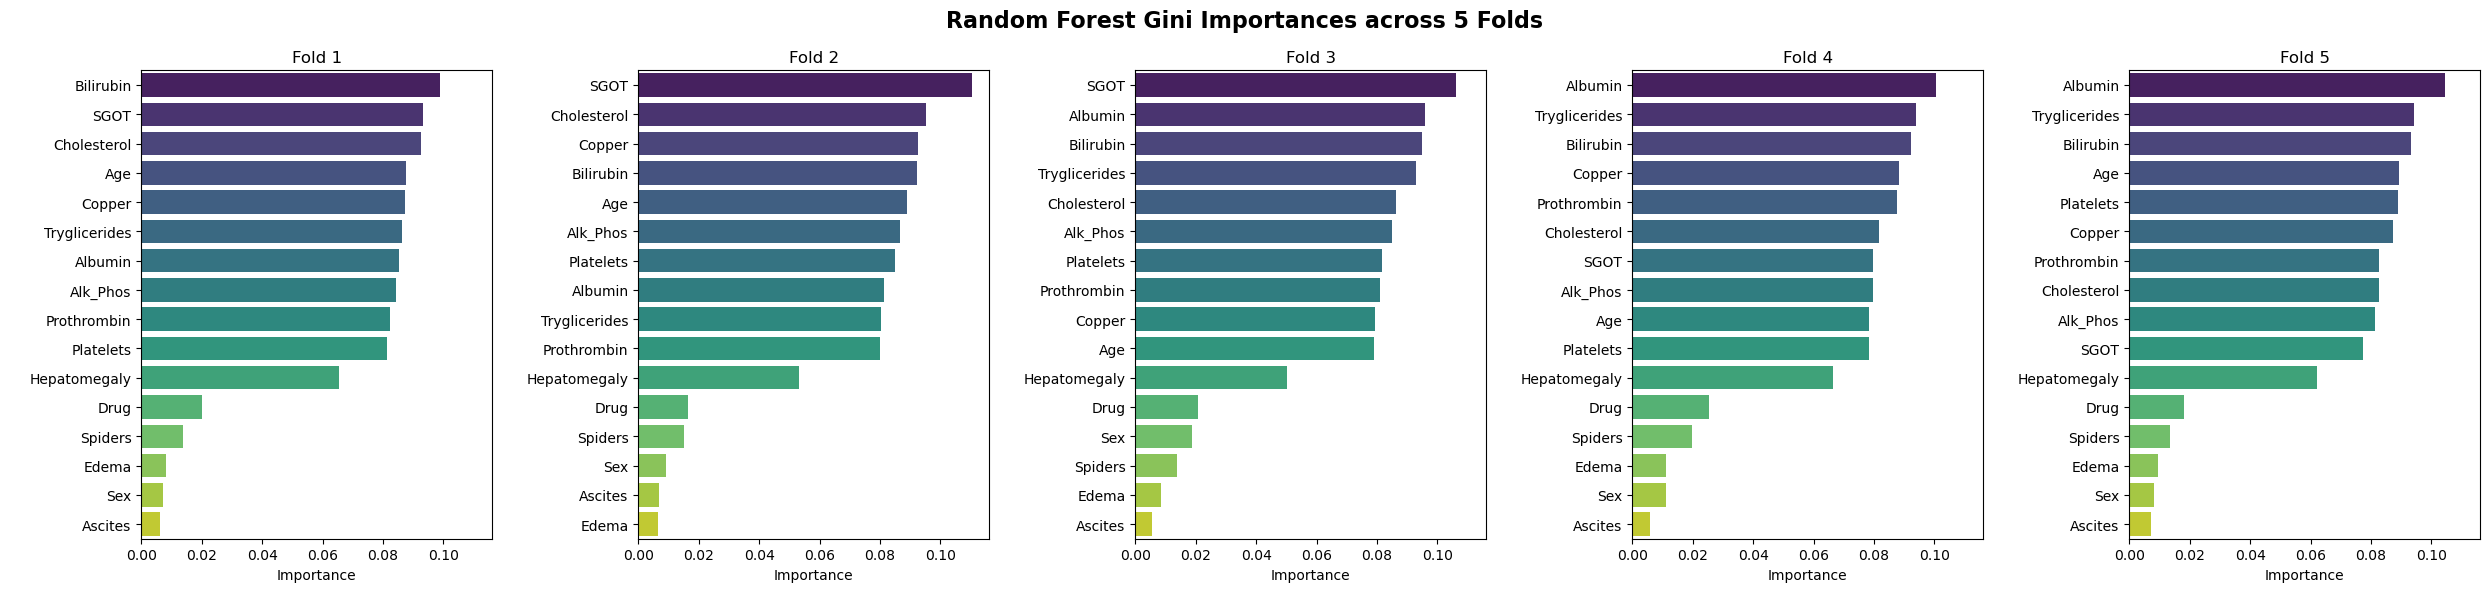

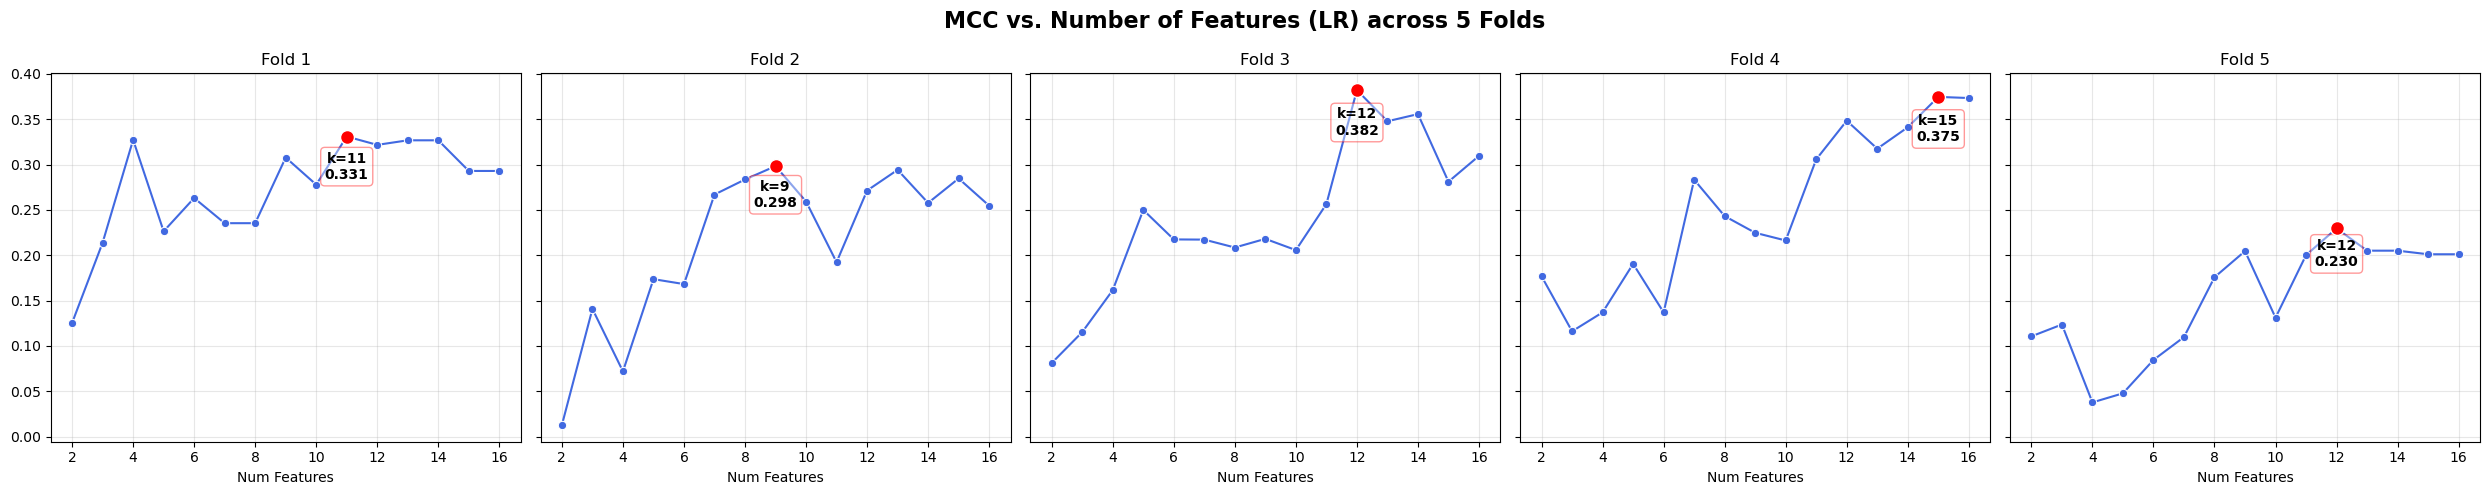

In [14]:
# initialize grids and models for Logistic Regression
C_grid = [0.1, 1.0, 10.0, 100.0]
estimator = LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42)
rf = best_model 

feature_counter = {}
results_gini = []
results_curve = []

for feature in training.drop(columns=['Set','Stage']).columns.tolist():
    feature_counter[feature] = feature_counter.get(0,0)
# iterate over the 5 cross-validation folds
for i in range(1, 6): 
    #-------dataset and estimator preparation----------------#
    # prepare train, validation, and test splits for the current fold
    training_sets = ((((i + 1) % 5) + 1), (((i + 2) % 5) + 1), (((i + 3) % 5) + 1)) 
    x_test, y_test = training.query(f"Set=='{i}'").drop(columns=['Set','Stage']), training.query(f"Set=='{i}'")['Stage']
    x_val, y_val = training.query(f"Set=='{((i)%5)+1}'").drop(columns=['Set','Stage']), training.query(f"Set=='{((i)%5)+1}'")['Stage']
    x_train, y_train = training.query(f"(Set=='{training_sets[0]}' or Set=='{training_sets[1]}' or Set=='{training_sets[2]}')").drop(columns=['Set','Stage']), training.query(f"(Set=='{training_sets[0]}' or Set=='{training_sets[1]}' or Set=='{training_sets[2]}')")['Stage']

    best_mcc = -1 
    best_params_base = None

    # Grid Search for Logistic regression hyperparameters using the validation set
    for C in C_grid: 
        estimator.set_params(C=C)
        estimator.fit(x_train, y_train) 
        y_pred = estimator.predict(x_val) 
        mcc = matthews_corrcoef(y_val, y_pred) 
            
        # keep the parameters that yield the best Validation MCC
        if mcc > best_mcc:
            best_mcc = mcc
            best_params_base = C

    #---------------feature evaluation by gini importance --------------#
    # Set the best parameters found
    estimator.set_params(C=best_params_base)
    
    # execute feature selection ranking
    gini_df, best_k, ks, curve = feat_sel(x_train, y_train, x_test, y_test, estimator, rf)

    # Store the resulting dataframes and curves for final plotting
    results_gini.append((i, gini_df)) 
    results_curve.append((i, ks, curve, best_k))
    
    # Update global feature counter with the selected top features
    for feature in gini_df["feature"].head(best_k):
        feature_counter[feature] = feature_counter.get(feature, 0) + 1 

#---------------------PLOTTING-------------#
# Plot 1: shows the features in order of importance (Gini importance)
fig1, axes1 = plt.subplots(1, 5, figsize=(25, 6), sharex=True)
fig1.suptitle('Random Forest Gini Importances across 5 Folds', fontsize=16, fontweight='bold')

for idx, (fold_num, fold_df) in enumerate(results_gini):
    ax = axes1[idx]
    

    sns.barplot(
        data=fold_df, 
        x="importance", 
        y="feature", 
        ax=ax, 
        palette="viridis", 
        hue="feature", 
        legend=False 
    )
    
    ax.set_title(f"Fold {fold_num}")
    ax.set_xlabel("Importance")
    ax.set_ylabel(" ")

plt.tight_layout()
plt.savefig('../figures/02_gini_imp_5cv_lr.svg', bbox_inches='tight')
plt.show()

# Plot 2: MCC Testing Curve per fold per different k number of features
fig2, axes2 = plt.subplots(1, 5, figsize=(25, 5), sharey=True) 
fig2.suptitle('MCC vs. Number of Features (LR) across 5 Folds', fontsize=16, fontweight='bold')

for idx, (fold_num, ks, curve, best_k) in enumerate(results_curve):
    ax = axes2[idx]
    
    # draw the main curve using Seaborn
    sns.lineplot(
        x=ks, 
        y=curve, 
        ax=ax, 
        marker="o", 
        color="royalblue" 
    )
    
    # highlight the best K point 
    best_mcc = curve[ks.index(best_k)]
    ax.scatter(best_k, best_mcc, color="red", s=100, zorder=5, edgecolor='white')
    
    # add text annotation for the best k (to make it more readable)
    ax.text(best_k, best_mcc - (max(curve)*0.05), 
            f"k={best_k}\n{best_mcc:.3f}", 
            ha='center', va='top', color='black', fontsize=10, fontweight='bold',
            bbox=dict(facecolor="white", alpha=0.4, edgecolor="red", boxstyle="round,pad=0.3"))
    
    ax.set_title(f"Fold {fold_num}")
    ax.set_xlabel("Num Features")
    ax.grid(True, alpha=0.3) 

plt.tight_layout()
plt.savefig('../figures/02_num_feat_5cv_lr.svg', bbox_inches='tight')
plt.show()

Feature to use: ['Age', 'Hepatomegaly', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
Number of features: 11


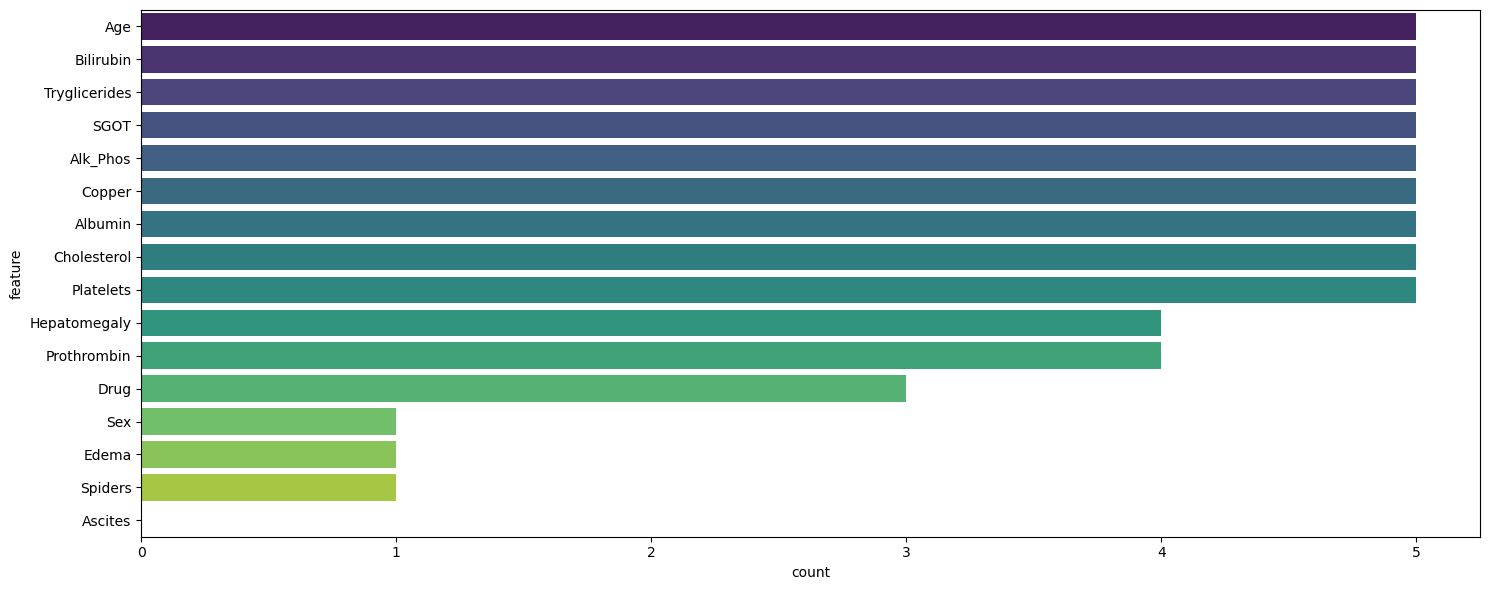

In [16]:
#Select the features that we will use for training the final model
features_to_use_lr= [k for k, v in feature_counter.items() if v >= 4]
print("Feature to use: "+ str(features_to_use_lr)+ "\n"+"Number of features: "+ str(len(features_to_use_lr)))

counter_df = pd.DataFrame(list(feature_counter.items()), columns=['feature', 'count'])
counter_df = counter_df.sort_values(by='count', ascending=False)
plt.figure(figsize=(15, 6))
sns.barplot(
    data=counter_df, 
    x="count", 
    y="feature", 
    palette="viridis",
    hue="feature",
    legend=False
    )
    

plt.tight_layout()
plt.savefig('../figures/02_counter_feat_lr.svg', bbox_inches='tight')
plt.show()

In [17]:
import joblib

output_path = '../data/'
os.makedirs(output_path, exist_ok=True)

df.to_csv('../data/data_refined_stratifkfold.csv', index=True)
print("StratifiedKfold dataset is saved in data/data_refined_stratifkfold.csv")

joblib.dump(features_to_use_tree, os.path.join(output_path, 'best_features_list_tree.pkl'))
print("Best feature list for balanced random forest model  saved in data/best_features_list_tree.pkl")

joblib.dump(features_to_use_svm, os.path.join(output_path, 'best_features_list_svm.pkl'))
print("Best feature list  for svm saved in data/best_features_list_svm.pkl")

joblib.dump(features_to_use_lr, os.path.join(output_path, 'best_features_list_lr.pkl'))
print("Best feature list  for linear regression based model saved in data/best_features_list_lr.pkl")

StratifiedKfold dataset is saved in data/data_refined_stratifkfold.csv
Best feature list for balanced random forest model  saved in data/best_features_list_tree.pkl
Best feature list  for svm saved in data/best_features_list_svm.pkl
Best feature list  for linear regression based model saved in data/best_features_list_lr.pkl
